In [19]:
# importing library
import pathlib
import os
import PIL
import cv2
from matplotlib import pyplot as plt
from tqdm import tqdm
import numpy as np 
from sklearn import model_selection
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [24]:
os.listdir()

['.ipynb_checkpoints',
 'antispoofing_big',
 'antispoofing_big.zip',
 'anti_spoofing_model.ipynb',
 'fake_real_image',
 'fake_real_image.zip',
 'logs',
 'real_and_fake_face']

### LOADING DATASET

In [2]:
IMAGE_PATH = 'real_and_fake_face'

image_dir = pathlib.Path(IMAGE_PATH)
image_dir

WindowsPath('real_and_fake_face')

In [3]:
img_path_fake = list(image_dir.glob('training_fake/*.jpg'))
len(img_path_fake)

960

In [4]:
img_path_real = list(image_dir.glob('training_real/*.jpg'))
len(img_path_real)

1081

In [5]:
img_path_fake[:5]

[WindowsPath('real_and_fake_face/training_fake/easy_100_1111.jpg'),
 WindowsPath('real_and_fake_face/training_fake/easy_101_0010.jpg'),
 WindowsPath('real_and_fake_face/training_fake/easy_102_0101.jpg'),
 WindowsPath('real_and_fake_face/training_fake/easy_103_1111.jpg'),
 WindowsPath('real_and_fake_face/training_fake/easy_104_1000.jpg')]

### EXPLORING DATA

### PLOTING SAMPLE IMAGES... 

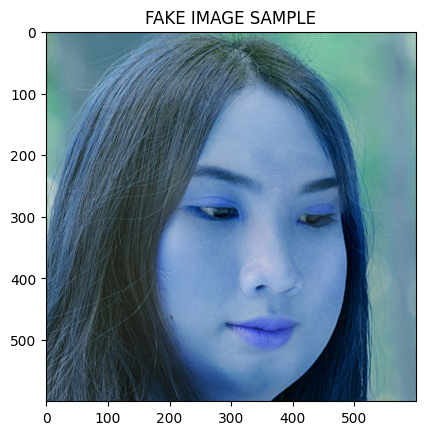

In [7]:
# FAKE SAMPLE IMAGE
sample_img_real = cv2.imread(str(img_path_fake[0]))
plt.imshow(sample_img_real)
plt.title('FAKE IMAGE SAMPLE')
plt.show()

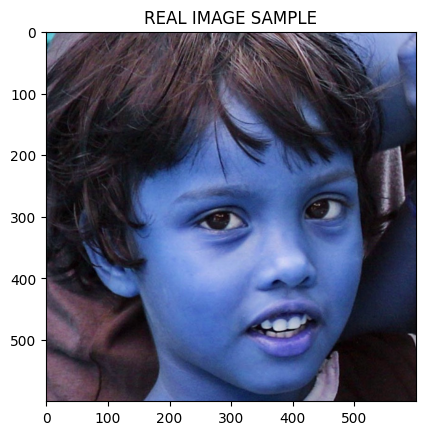

In [8]:
# REAL SAMPLE IMAGE
PIL.Image.open(str(img_path_real[2]))
# os.path.join('real_and_fake_face', 'training_fake', 'easy_100_111.jpg')
sample_img_fake = cv2.imread(str(img_path_real[0]))
plt.imshow(sample_img_fake)
plt.title('REAL IMAGE SAMPLE')
plt.show()

### loading Fake & Real Image Dataset 

In [120]:
# defining image generator
IMAGE_PATH = 'real_and_fake_face'
facial_img = ImageDataGenerator(rescale=1./255, horizontal_flip=True, vertical_flip=True)

In [121]:
# loading from directory
train_face_dataset = facial_img.flow_from_directory(directory=IMAGE_PATH, target_size=(96,96), batch_size=40, class_mode='binary', color_mode='rgb', shuffle=True)

Found 2041 images belonging to 2 classes.


In [122]:
train_face_dataset.image_shape

(96, 96, 3)

In [123]:
train_face_dataset.classes

array([0, 0, 0, ..., 1, 1, 1])

In [124]:
train_face_dataset.class_indices

{'training_fake': 0, 'training_real': 1}

In [106]:
from matplotlib import image

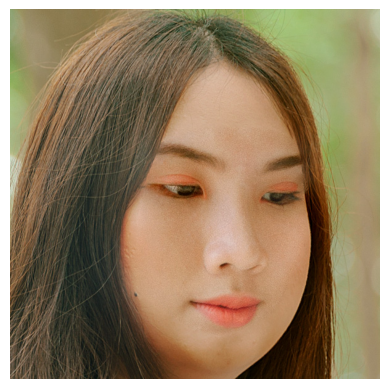

In [77]:
img = image.imread(os.path.join('real_and_fake_face', str(train_face_dataset.filenames[0])))
plt.axis('off')
plt.imshow(img)

### Loading DenseNet Model

In [107]:
# MODEL ARCHITECTURE
from keras.applications.densenet import DenseNet169
from tensorflow import keras
from keras.utils import plot_model
import tensorflow as tf

In [108]:
densnet_model = DenseNet169(weights='imagenet', include_top=False)

In [109]:
print('Numbers of Densnet Layer: ' , len(densnet_model.layers))

Numbers of Densnet Layer:  595


In [110]:
print('LAST 10 LAYERS OF THE DENSNET MODEL')
densnet_model.layers[-10:]

LAST 10 LAYERS OF THE DENSNET MODEL


In [17]:
# let make the cov5 layer non trainaible 
for layer in densnet_model.layers: 
    if 'cov5' in layer.name:
        # retrain the parameter
        layer.trainable = True
    else:
        # keep the weight static
        layer.trainable = False
        

In [11]:
densnet_model.summary()

Model: "densenet169"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 102, 102, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 48, 48, 64)   9408        ['zero_padding2d[0][0]']         
                                                                                                  
 conv1/bn (BatchNormalization)  (None, 48, 48, 64)   256         ['conv1/conv[0][0]']             
                                                                                        

In [113]:
# input layer
input_layer = keras.layers.Input(shape=(96,96,3))

# Densnet achitecuture model layers 
densenet_output = densnet_model(input_layer)

# dense layer
out = flatten_layer = keras.layers.Flatten()(densenet_output)
output = keras.layers.BatchNormalization()(out)
output1 = keras.layers.Dense(256, activation='relu')(output)
final_output = keras.layers.Dense(1, activation='sigmoid')(output1)

spoofing_model = keras.models.Model(inputs=[input_layer], outputs=[final_output])

In [114]:
spoofing_model.compile(
        optimizer='Adam', 
        loss='binary_crossentropy',
        metrics=['accuracy']
)

In [115]:
spoofing_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 densenet169 (Functional)    (None, None, None, 1664)  12642880  
                                                                 
 flatten_1 (Flatten)         (None, 14976)             0         
                                                                 
 batch_normalization_1 (Batc  (None, 14976)            59904     
 hNormalization)                                                 
                                                                 
 dense_3 (Dense)             (None, 256)               3834112   
                                                                 
 dense_4 (Dense)             (None, 1)                 257       
                                                           

In [116]:
# visulaizing and ploting model
plot_model(spoofing_model, 'spoofing.png')

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [117]:
# taining model
logdir = 'logs'
call_back = tf.keras.callbacks.TensorBoard(log_dir=logdir)
spoofing_model.fit(train_face_dataset, callbacks=call_back, epochs=22)

Epoch 1/22
52/52 [==============================] - 469s 8s/step - loss: 1.6631 - accuracy: 0.5282
Epoch 2/22
52/52 [==============================] - 411s 8s/step - loss: 0.9580 - accuracy: 0.5571
Epoch 3/22
52/52 [==============================] - 409s 8s/step - loss: 0.8548 - accuracy: 0.5409
Epoch 4/22
50/52 [===========================>..] - ETA: 20s - loss: 0.7089 - accuracy: 0.5436

KeyboardInterrupt: 

In [129]:
# Evaluaating the model
spoofing = tf.keras.models.load_model('spoofing_model.h5')

TypeError: weight_decay is not a valid argument, kwargs should be empty  for `optimizer_experimental.Optimizer`.

In [ ]:
# IMAGE SIZE
sample_img_real.shape
sample_img_fake.shape

In [ ]:
# LOADING IMAGE FROM DIR
image_dataset_dict={
    'real': img_path_real, 
    'fake': img_path_fake
}


image_dataset_dict['real'][:10]
image_dataset_dict['fake'][:10]
# image_dataset_dict

In [11]:
 image_label_dict = {
      
     'fake':0, 
     'real':1
 }
    
image_label_dict

{'fake': 0, 'real': 1}

In [27]:
# for key, img  in image_dataset_dict.items():
#     print(key, img)
#     # for im in img: 
#     #     print(im)

LOADING OF IMAGE AS NUMPY ARRAY

In [17]:
X = []
y = []


for key, image in tqdm(image_dataset_dict.items()): 
    for img in image:
        img = cv2.imread(str(img))
        reshape_image = cv2.resize(img, (180,180))
        X.append(reshape_image)
        y.append(image_label_dict[key])

100%|████████████████████████████████████| 2/2 [00:22<00:00, 11.19s/it]


In [12]:
fake_image = []
real_image = []
fake_label = np.zeros(len(img_path_fake))
real_label = np.ones(len(img_path_real))


for key, image in tqdm(image_dataset_dict.items()):
    for img in image:
        img = cv2.imread(str(img))
        reshape_image = cv2.resize(img, (224,224))
        # X.append(reshape_image)
        # y.append(image_label_dict[key])
        if image_label_dict[key] == 0: 
          fake_image.append(reshape_image)
        else: 
          real_image.append(reshape_image)

100%|████████████████████████████████████| 2/2 [00:44<00:00, 22.44s/it]


In [15]:
# len(fake_image)
# len(fake_label)

In [21]:
# converting it to a numpy array
fake_image= np.array(fake_image)
real_image= np.array(real_image)

In [65]:
image_genrator = ImageDataGenerator(brightness_range=(0.8,1.2), rotation_range=30, width_shift_range=0.2, height_shift_range=0.2)
aug_real_image = image_genrator.flow(real_image, ignore_class_split=True, save_to_dir='aug_real')
aug_fake_image = image_genrator.flow(fake_image, ignore_class_split=True, save_to_dir='aug_fake')

In [ ]:
def load_image_from_disk(image_path):
    pass

In [74]:
aug_real = aug_real_image.next()
# np.append(real_image, aug_real)
aug_fake = aug_fake_image.next()
# np.append(fake_image, aug_fake)

In [75]:
len(fake_image)

960

In [50]:
# # converting to 
# X = np.array(X)
# y = np.array(y)

[1, 1, 1, 1]


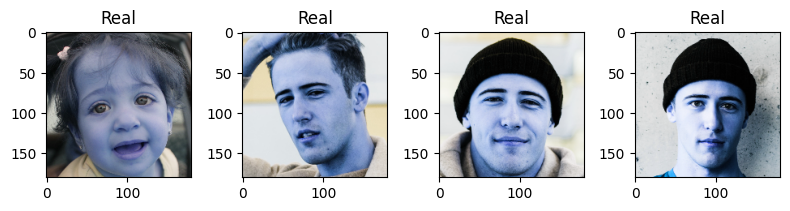

In [40]:
# def plot_images(images, im_count, title): 
#     fig , ax = plt.subplots(nrows=1, ncols=im_count, figsize=(8, 8))

#     suffle = np.random.choice(len(images))
#     print(suffle)
#     images = images
#     if suffle < (len(images) - im_count): 
#         images = images[suffle:suffle+im_count]
#     else: 
#         images = images[suffle:]
        
    
#     images = images[suffle:suffle+im_count]
    
#     for idx, img in enumerate(images): 
#         # row = idx // 2 
#         # col = idx % 2
#         # print(col)
#         print(idx)
#         print(ax[idx].imshow(img))
#         ax[idx].set_title(title)
        
# plot_images(X[:30] ,4, 'Real')

suffle = np.random.choice(len(X))

fig , ax = plt.subplots(nrows=1, ncols=4, figsize=(8, 8))

images = X[suffle:suffle+4]
labels = y[suffle:suffle+4]
print(labels)
for idx, img in enumerate(images):     
    ax[idx].imshow(img)
    if labels[idx] == 1: 
        ax[idx].set_title('Real')
    else: 
        ax[idx].set_title('fake')
    

plt.tight_layout()
plt.show()

[1, 1, 1, 1]


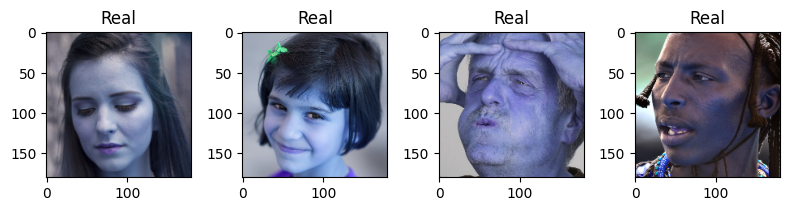

In [41]:

suffle = np.random.choice(len(X))

fig , ax = plt.subplots(nrows=1, ncols=4, figsize=(8, 8))

images = X[suffle:suffle+4]
labels = y[suffle:suffle+4]
print(labels)
for idx, img in enumerate(images):     
    ax[idx].imshow(img)
    if labels[idx] == 1: 
        ax[idx].set_title('Real')
    else: 
        ax[idx].set_title('fake')
    

plt.tight_layout()
plt.show()

In [17]:
type(X)

numpy.ndarray

### SCALLING IMAGE

In [42]:
# X_scalled = []
# for x in tqdm(X): 
#     X_scalled.append(x/255)

In [43]:
# X_scalled = np.array(X_scalled)
# plt.imshow(X_scalled[0])

In [44]:
# type(X_scalled)
 
X = np.array(X)
y = np.array(y)

In [47]:
# splitting dataset 
X_train, X_test, y_train, y_test  = model_selection.train_test_split(X, y, test_size=.15, random_state=0)

In [59]:
X_train_scaled = X_train / 255
X_test_scaled = X_test / 255
X_train_scaled.shape

(1734, 180, 180, 3)

In [ ]:
len(y_train)

In [207]:
X_test.shape

(409, 224, 224, 3)

In [1]:
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras.applications import VGG16

In [2]:
vgg_layers = VGG16(include_top=False)

In [50]:
vgg_layers.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [51]:

SHAPE = (224,224,3)

# input layer
input_layer = keras.layers.Input(shape=SHAPE)

# vgg19 model layers 
vgg_output = vgg_layers(input_layer)

# dense layer
output = keras.layers.GlobalMaxPooling2D()(vgg_output)
final_output = keras.layers.Dense(1, activation='sigmoid')(output)

spoofing_model = keras.models.Model(inputs=[input_layer], outputs=[final_output])

In [53]:
spoofing_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 global_max_pooling2d (Globa  (None, 512)              0         
 lMaxPooling2D)                                                  
                                                                 
 dense (Dense)               (None, 2048)              1050624   
                                                                 
 dense_1 (Dense)             (None, 1)                 2049      
                                                                 
Total params: 15,767,361
Trainable params: 15,767,361
Non-trainable params: 0
_________________________________________________

In [54]:
# COMPILATION PARAMETER
spoofing_model.compile(
    optimizer=tf.keras.optimizers.Adam(
    learning_rate=0.000001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07), 
    loss= tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy']
)

In [55]:
logdir = 'logs'
call_back = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [247]:
training_history = spoofing_model.fit(X_train_scaled, y_train, validation_data=(X_test_scaled, y_test), epochs = 5, batch_size=20, callbacks=[call_back])

Epoch 1/5
 7/82 [=>............................] - ETA: 38:28 - loss: 0.7505 - accuracy: 0.4286

KeyboardInterrupt: 

In [57]:
from sklearn import metrics
from keras.preprocessing.image import ImageDataGenerator

In [73]:
train_data_gen = ImageDataGenerator(brightness_range=(0.8,1.2), rotation_range=30, width_shift_range=0.2, height_shift_range=0.2)

In [ ]:
X_train = train_data_gen.flow(X_train, ignore_class_split=True)

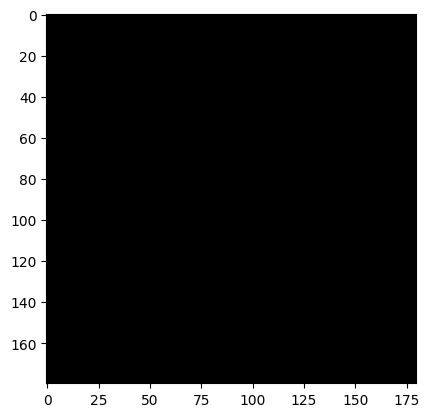

In [70]:
plt.imshow(X_train.next()[1])

In [1]:
import cv2
import numpy as np 
face_cascade_classifier = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
vid = cv2.VideoCapture(0)
while True: 
    # print('code get here')
     
    ret, frame = vid.read()
    gray = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
    img_face = face_cascade_classifier.detectMultiScale(gray, 1.3, 5)

    for (x, y, w, h) in img_face:
        face = frame[y-5:y+h+5, x-5:x+w+5]
        face_resize = cv2.resize(face, (160,160))
        face_resize = face_resize.astype('float') / 255.0
        face_resize = np.expand_dims(face_resize, axis=0)

#             show bouding box 
        cv2.putText(frame, 'image', (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255,0), 2)
        cv2.rectangle(frame, (x,y), (x+w, y+h), (0,255,0) ,2)

    cv2.imshow('frame', frame)

    if cv2.waitKey(1) == ord('q'): 
        break
   
    
vid.release()
cv2.destroyAllWindows()

In [5]:
from keras.models import load_model
import os 
print(os.listdir())


['.ipynb_checkpoints', 'antispoofing_big', 'anti_spoofing_model.ipynb', 'aug_fake', 'aug_real', 'fake_real_image', 'IMAGES', 'logs', 'model', 'real_and_fake_face', 'spoofing_model.h5']


In [9]:
vgg = load_model(os.path.join('model', 'spoofing_model.h5'), compile=False)
vgg.compile(  
    optimizer='Adam', 
    loss='binary_crossentropy', 
    metrics=['accuracy'])

In [11]:
vgg.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 global_max_pooling2d_4 (Glo  (None, 512)              0         
 balMaxPooling2D)                                                
                                                                 
 dense_8 (Dense)             (None, 128)               65664     
                                                                 
 dense_9 (Dense)             (None, 1)                 129       
                                                                 
Total params: 14,780,481
Trainable params: 65,793
Non-trainable params: 14,714,688
__________________________________________